In [ ]:
# Import the torch modules
import torch
import torch.optim as optim
import torch.nn as nn

# __call__ in Python
Python has a set of built-in methods and __call__ is one of them. The __call__ method enables Python programmers to write classes where the instances behave like functions and can be called like a function. When the instance is called as a function; if this method is defined, x(arg1, arg2, ...) is a shorthand for x.__call__(arg1, arg2, ...).

https://www.geeksforgeeks.org/__call__-in-python/


In [ ]:
class Example:
    def __init__(self):
        print("Instance Created")

    # Defining __call__ method
    def __call__(self):
        print("Instance is called via special method")

# Instance created
e = Example()

# __call__ method will be called
e()

Instance Created
Instance is called via special method


In [ ]:
class Product:
    def __init__(self):
        print("Instance Created")

    # Defining __call__ method
    def __call__(self, a, b):
        print(a * b)

# Instance created
ans = Product()

# __call__ method will be called
ans(10, 20)

Instance Created
200


# Torch.nn
PyTorch has a whole submodule dedicated to neural networks, called **torch.nn**. It contains the building blocks needed to create all sorts of neural network architectures.

Those building blocks are called modules in PyTorch parlance.
> - A PyTorch module is a Python class deriving from the nn.Module base class. A module can have one or more Parameter instances as attributes, which are tensors whose values are optimized during the training process (think w and b in our linear model).
> - A module can also have one or more submodules (subclasses of nn.Module) as attributes, and it will be able to track their parameters as well. (for example, a subclass of nn.Module called nn.Linear)

## Using "\_\_call\_\_" rather than "forward"

All PyTorch-provided subclasses of nn.Module have their \_\_call\_\_ method defined. This allows us to instantiate an nn.Linear and call it as if it was a function.

> - Calling an instance of nn.Module with a set of arguments ends up calling a method named forward with the same arguments. The forward method is what executes the forward computation, while \_\_call\_\_() does other rather important chores before and after calling forward.

Here’s the implementation of Module.\_\_call\_\_()

![16.PNG](attachment:966f3aff-559d-4e43-bc31-12c34bf301e2.PNG)

So, it is technically possible to call forward directly, and it will produce the same output as __call__, but this should not be done from user code:

![17.png](attachment:ace58b17-b9fd-41d6-9759-6db6392debbe.png)

In [ ]:
# prepare datasets
t_c = [0.5,  14.0, 15.0, 28.0, 11.0,  8.0,  3.0, -4.0,  6.0, 13.0, 21.0]
t_u = [35.7, 55.9, 58.2, 81.9, 56.3, 48.9, 33.9, 21.8, 48.4, 60.4, 68.4]

# To accommodate multiple samples, modules expect the zeroth dimension of the input to be the number of samples in the batch
# we would need to add an extra dimension to turn that 1D tensor into a matrix with samples in the rows and features in the columns.
t_c = torch.tensor(t_c).unsqueeze(1) # Adds the extra dimension at axis 1
t_u = torch.tensor(t_u).unsqueeze(1) #

print('t_u.shape -->', t_u.shape)

n_samples = t_u.shape[0]
n_val = int(0.2 * n_samples)

shuffled_indices = torch.randperm(n_samples)

train_indices = shuffled_indices[:-n_val]
val_indices = shuffled_indices[-n_val:]

t_u_train = t_u[train_indices]
t_c_train = t_c[train_indices]

t_u_val = t_u[val_indices]
t_c_val = t_c[val_indices]

t_un_train = 0.1 * t_u_train
t_un_val = 0.1 * t_u_val

print('t_un_train.shap -->', t_un_train.shape)
print('t_un_val.shape -->', t_un_val.shape)

t_u.shape --> torch.Size([11, 1])
t_un_train.shap --> torch.Size([9, 1])
t_un_val.shape --> torch.Size([2, 1])


In [ ]:
#
linear_model = nn.Linear(1, 1) #The arguments are input size, output size, and bias defaulting to True
print(linear_model(t_un_val))

tensor([[1.6337],
        [1.7024]], grad_fn=<AddmmBackward0>)
Parameter containing:
tensor([[0.3124]], requires_grad=True)
Parameter containing:
tensor([-0.1842], requires_grad=True)


## Get parameters

In [ ]:
print(linear_model.weight)
print(linear_model.bias)

# or the .parameters() call recurses into submodules defined in the module’s init constructor and returns a flat list of all parameters encountered,
# so that we can conveniently pass it to the optimizer constructor as we did previously

list(linear_model.parameters())

Parameter containing:
tensor([[0.3124]], requires_grad=True)
Parameter containing:
tensor([-0.1842], requires_grad=True)


[Parameter containing:
 tensor([[0.3124]], requires_grad=True),
 Parameter containing:
 tensor([-0.1842], requires_grad=True)]

## Built-in loss functions in Torch.nn
Torch.nn comes with several common loss functions, among them nn.MSELoss (MSE stands for Mean Square Error), which is exactly what we defined earlier as our loss_fn.

https://pytorch.org/docs/stable/nn.html#loss-functions

In [ ]:
def training_loop(n_epochs, optimizer, model, loss_fn, t_u_train, t_u_val,
                  t_c_train, t_c_val):
    for epoch in range(1, n_epochs + 1):
        t_p_train = model(t_u_train) # <1>
        loss_train = loss_fn(t_p_train, t_c_train)

        t_p_val = model(t_u_val) # <1>
        loss_val = loss_fn(t_p_val, t_c_val)

        optimizer.zero_grad()
        loss_train.backward() # <2>
        optimizer.step()

        if epoch == 1 or epoch % 1000 == 0:
            print(f"Epoch {epoch}, Training loss {loss_train.item():.4f},"
                  f" Validation loss {loss_val.item():.4f}")

In [ ]:
linear_model = nn.Linear(1, 1)
optimizer = optim.SGD(linear_model.parameters(), lr=1e-2)

training_loop(
    n_epochs = 3000,
    optimizer = optimizer,
    model = linear_model,
    loss_fn = nn.MSELoss(), # note: we are no longer using our hand-written loss function from earlier
    t_u_train = t_un_train,
    t_u_val = t_un_val,
    t_c_train = t_c_train,
    t_c_val = t_c_val)

print()
print(linear_model.weight)
print(linear_model.bias)

Epoch 1, Training loss 322.0737, Validation loss 535.9867
Epoch 1000, Training loss 3.4301, Validation loss 4.2528
Epoch 2000, Training loss 2.8864, Validation loss 3.3530
Epoch 3000, Training loss 2.8758, Validation loss 3.2471

Parameter containing:
tensor([[5.2911]], requires_grad=True)
Parameter containing:
tensor([-16.8850], requires_grad=True)


In [ ]:
# for comparsion, the following recall the hand-written loss function from earlier

def loss_fn(t_p, t_c):
    squared_diffs = (t_p - t_c)**2
    return squared_diffs.mean()

linear_model = nn.Linear(1, 1) # <1>
optimizer = optim.SGD(linear_model.parameters(), lr=1e-2)

training_loop(
    n_epochs = 3000,
    optimizer = optimizer,
    model = linear_model,
    loss_fn = loss_fn,
    t_u_train = t_un_train,
    t_u_val = t_un_val,
    t_c_train = t_c_train,
    t_c_val = t_c_val)

print()
print(linear_model.weight)
print(linear_model.bias)

Epoch 1, Training loss 129.7419, Validation loss 216.9386
Epoch 1000, Training loss 3.5077, Validation loss 4.3342
Epoch 2000, Training loss 2.8879, Validation loss 3.3615
Epoch 3000, Training loss 2.8758, Validation loss 3.2482

Parameter containing:
tensor([[5.2905]], requires_grad=True)
Parameter containing:
tensor([-16.8819], requires_grad=True)


# nn.Sequential()

Let’s build the simplest possible neural network: a linear module, followed by an activation function, feeding into another linear module.

Torch.nn provides a simple way to concatenate modules through the **nn.Sequential** container.

Our simplest neural network in two views. Left: beginner’s version. Right: higher-level version
![18.PNG](attachment:f7169ce0-4c8e-4b21-a517-a9cad4813482.PNG)


In [ ]:
seq_model = nn.Sequential(
            nn.Linear(1, 13), # We chose 13 arbitrarily. We wanted a number that was a different size from the other tensor shapes we have floating around.
            nn.Tanh(),
            nn.Linear(13, 1)) # This 13 must match the first size, however

# check the structure
print(seq_model)
print()

# check parameters
for param in seq_model.parameters():
    print(param)

Sequential(
  (0): Linear(in_features=1, out_features=13, bias=True)
  (1): Tanh()
  (2): Linear(in_features=13, out_features=1, bias=True)
)

Parameter containing:
tensor([[ 0.0290],
        [-0.2762],
        [ 0.9379],
        [-0.4697],
        [-0.7614],
        [-0.2705],
        [ 0.9577],
        [-0.7817],
        [-0.8645],
        [-0.5539],
        [ 0.7091],
        [ 0.7760],
        [ 0.9896]], requires_grad=True)
Parameter containing:
tensor([ 0.4740, -0.7024,  0.4107,  0.4360,  0.1069,  0.4710, -0.1674, -0.2225,
         0.9772,  0.7713,  0.5056, -0.0467,  0.4916], requires_grad=True)
Parameter containing:
tensor([[-0.0239, -0.2314, -0.2428,  0.0318, -0.1432, -0.2078, -0.1338,  0.1011,
          0.2220,  0.0857,  0.2752, -0.1702, -0.0228]], requires_grad=True)
Parameter containing:
tensor([-0.1733], requires_grad=True)


In [ ]:
optimizer = optim.SGD(seq_model.parameters(), lr=1e-3) # <1>

training_loop(
    n_epochs = 5000,
    optimizer = optimizer,
    model = seq_model,
    loss_fn = nn.MSELoss(),
    t_u_train = t_un_train,
    t_u_val = t_un_val,
    t_c_train = t_c_train,
    t_c_val = t_c_val)

print('output', seq_model(t_un_val))
print('answer', t_c_val)

Epoch 1, Training loss 2.0203, Validation loss 1.0584
Epoch 1000, Training loss 2.0125, Validation loss 1.0384
Epoch 2000, Training loss 2.0069, Validation loss 1.0408
Epoch 3000, Training loss 2.0019, Validation loss 1.0476
Epoch 4000, Training loss 1.9974, Validation loss 1.0540
Epoch 5000, Training loss 1.9931, Validation loss 1.0612
output tensor([[12.4021],
        [20.6043]], grad_fn=<AddmmBackward0>)
answer tensor([[11.],
        [21.]])


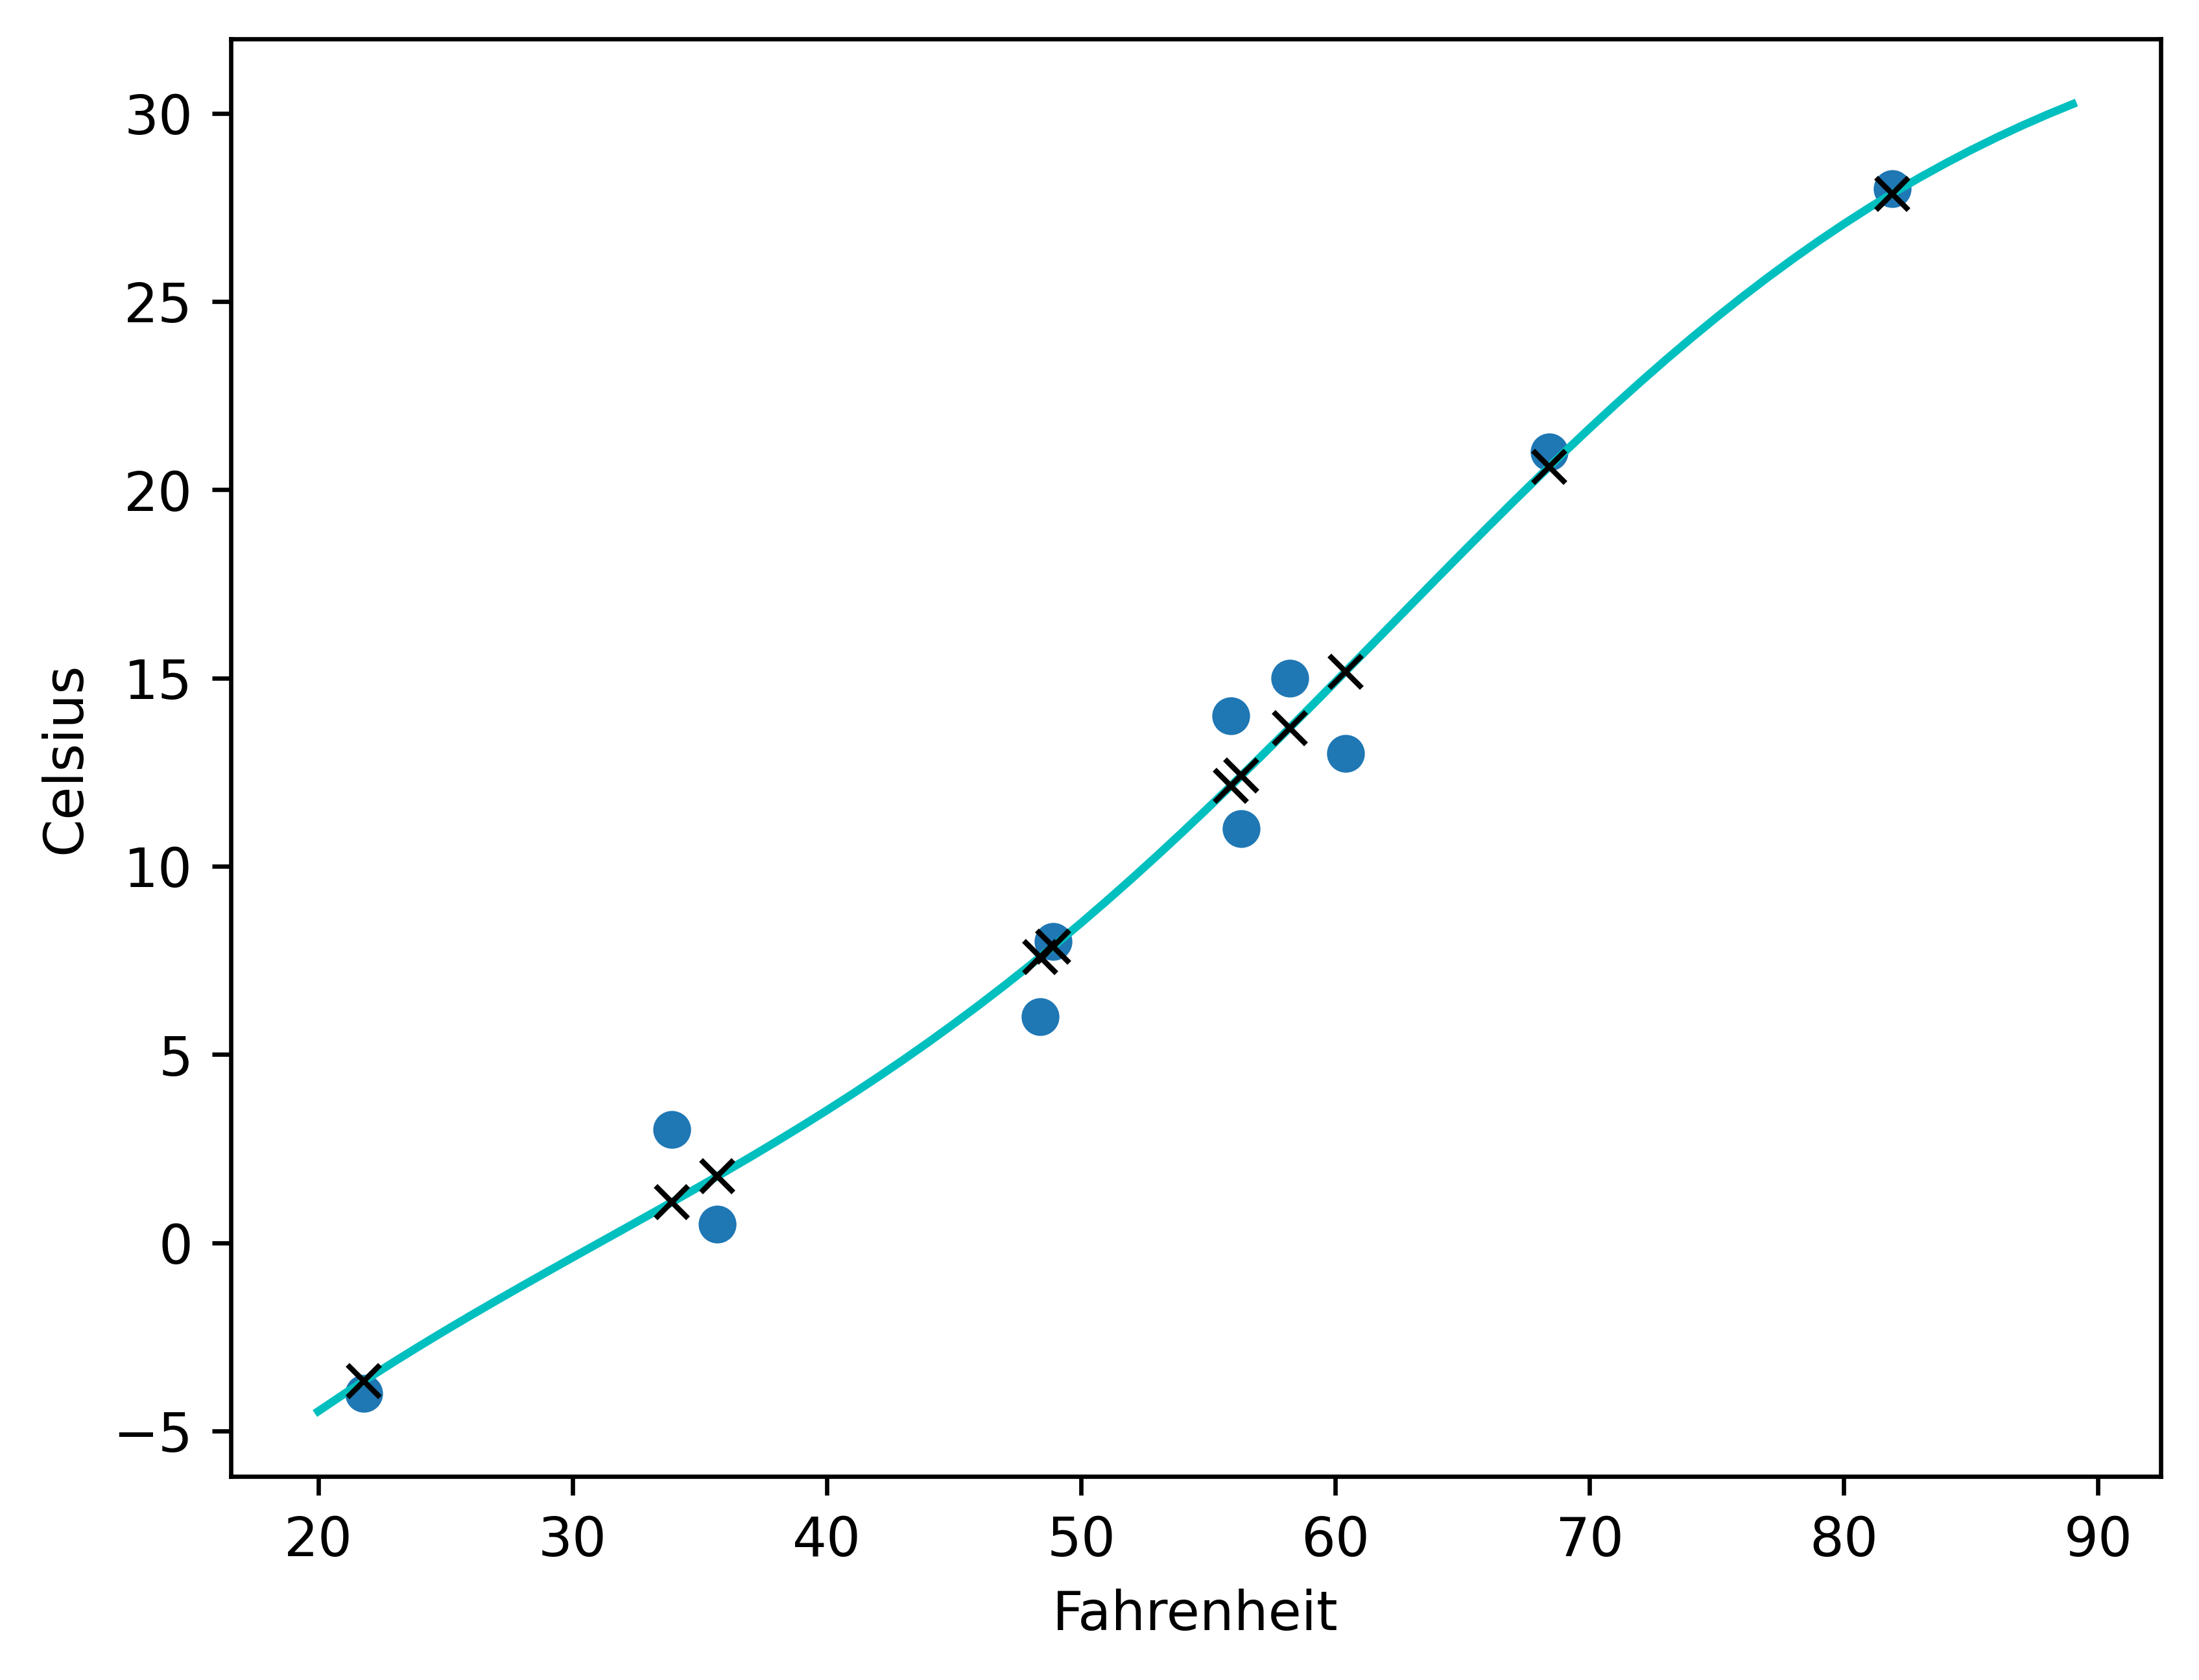

In [ ]:
from matplotlib import pyplot as plt

t_range = torch.arange(20., 90.).unsqueeze(1)

fig = plt.figure(dpi=600)
plt.xlabel("Fahrenheit")
plt.ylabel("Celsius")
plt.plot(t_u.numpy(), t_c.numpy(), 'o')
plt.plot(t_range.numpy(), seq_model(0.1 * t_range).detach().numpy(), 'c-')
plt.plot(t_u.numpy(), seq_model(0.1 * t_u).detach().numpy(), 'kx')